In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline  

In [2]:
%cd /Users/rihiko/Desktop/AD654/Project

/Users/rihiko/Desktop/AD654/Project


### Forecasting Total Spending (10 points)​: 
Using the ​nyc_to_ne_leisurepark data, build a model that predicts the total spending by greater NYC visitors to New England parks for each of the next five years. Bear in mind that there is no trend, and no seasonality, in the dataset that you will use for this.
In a markdown cell, write one paragraph that describes your process and results.

In [3]:
data = pd.read_csv("nyc_to_ne.csv",index_col='year', parse_dates=True)

#### Data Exploration

In [4]:
data.head()

,summerspend
year,
1959-01-01,2.262733e+07
1960-01-01,3.050980e+07
1961-01-01,2.440828e+07
1962-01-01,2.377221e+07
1963-01-01,2.357277e+07


In [5]:
data.index

DatetimeIndex(['1959-01-01', '1960-01-01', '1961-01-01', '1962-01-01',
               '1963-01-01', '1964-01-01', '1965-01-01', '1966-01-01',
               '1967-01-01', '1968-01-01', '1969-01-01', '1970-01-01',
               '1971-01-01', '1972-01-01', '1973-01-01', '1974-01-01',
               '1975-01-01', '1976-01-01', '1977-01-01', '1978-01-01',
               '1979-01-01', '1980-01-01', '1981-01-01', '1982-01-01',
               '1983-01-01', '1984-01-01', '1985-01-01', '1986-01-01',
               '1987-01-01', '1988-01-01', '1989-01-01', '1990-01-01',
               '1991-01-01', '1992-01-01', '1993-01-01', '1994-01-01',
               '1995-01-01', '1996-01-01', '1997-01-01', '1998-01-01',
               '1999-01-01', '2000-01-01', '2001-01-01', '2002-01-01',
               '2003-01-01', '2004-01-01', '2005-01-01', '2006-01-01',
               '2007-01-01', '2008-01-01', '2009-01-01', '2010-01-01',
               '2011-01-01', '2012-01-01', '2013-01-01', '2014-01-01',
      

**Given 61 years of data(1959-2019) at yearly level with the number of commuters travelling, we need to predict the total spending by greater NYC visitors to New England parks for each of the next five years.**

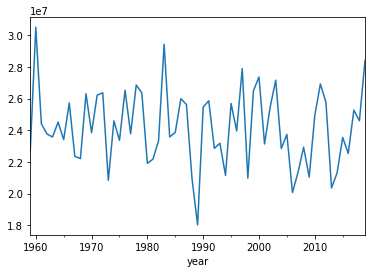

In [6]:
data['summerspend'].plot();

#### Creating train and test datasets for modeling
Because we need to capture the time factor in time series data, I devided total data as training data and test data by time. The first 70% older data is training data, and 30% newer data is test data.

In [7]:
#Index 42 marks 2001-01-01
train=data[0:42] 
test=data[42:]

Let’s visualize the data (train and test together) to know how it varies over a time period.

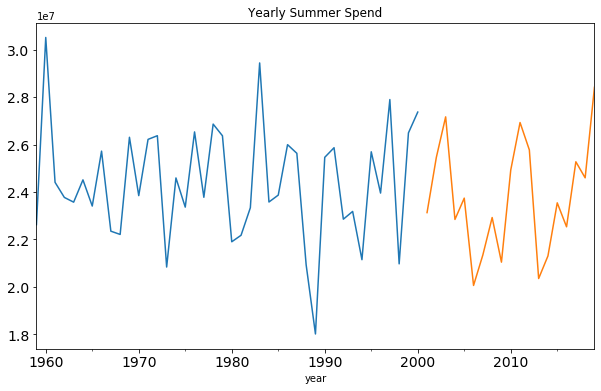

In [8]:
#Plotting data
train.summerspend.plot(figsize=(10,6), title= 'Yearly Summer Spend', fontsize=14)
test.summerspend.plot(figsize=(10,6), title= 'Yearly Summer Spend', fontsize=14)
plt.show()

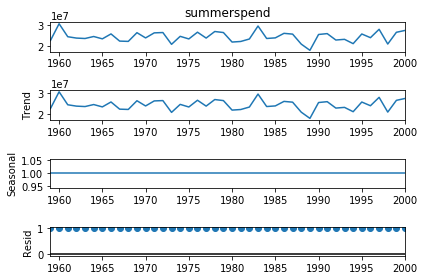

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(train['summerspend'], model='multiplicative')  # model='mul' also works
result.plot();

In [10]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib import pyplot
import statsmodels.api as sm

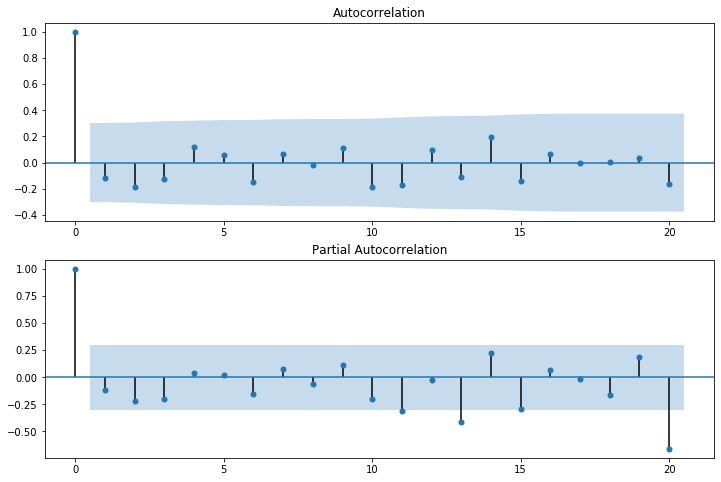

In [11]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(train,lags=20,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(train,lags=20,ax=ax2)

* According to the ETS decomposition, there is no significant seasonal and trend. Therefore, we will not consider the seasonal model, such as SARIMAX, Holt-Winters, Holt’s Linear Trend.

* What's more, this time series seems to be stationary. Both ACF and PACF fall into confidence interval abruptly, cutting off at q = 0 and p = 0,respectively. But for more precisely prediction, we will try AR(1), MA(1), ARMA(1,1) in the following modeling process. 




#### Modeling
We use training dataset for modeling, and test dataset to measure the performance of models. The performance indicator mainly is RMSE. But we also use AIC and BIC to measure the performances of AR(1), MA(1), ARMA(1,1) , to select the best model in ARMA.

In [12]:
RMSE = [] # collect rmse of all the models

##### Method 1: Naive Approach

In [13]:
# Consider the process is no trend and no seasonal factor, we apply the Naive Approach at first

##### ((((((( We can infer from the graph that the price of the coin is stable from the start. Many a times we are provided with a dataset, which is stable throughout it’s time period. If we want to forecast the price for the next day, we can simply take the last day value and estimate the same value for the next day. Such forecasting technique which assumes that the next expected point is equal to the last observed point is called Naive Method.

$$\hat{y}_{t+1} = y_t$$

In [14]:
import statsmodels

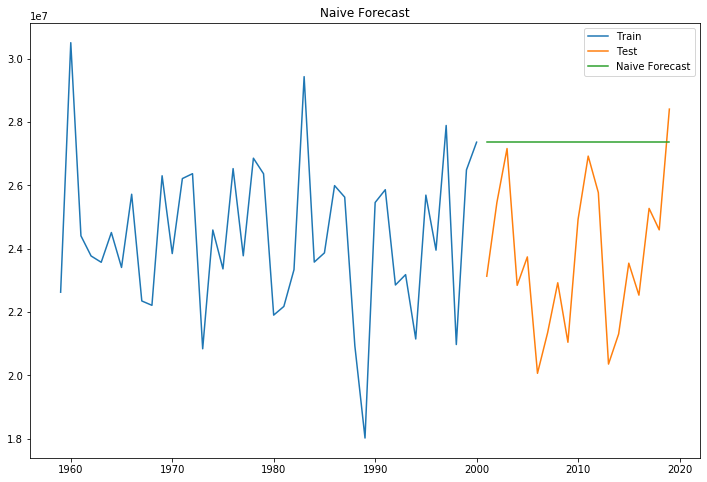

In [15]:
# Now we will implement the Naive method to forecast the prices for test data.

train_summerspend = np.asarray(train.summerspend)
y_hat = test.copy()
y_hat['naive'] = train_summerspend[len(train_summerspend)-1]
plt.figure(figsize=(12,8))
plt.plot(train.index, train['summerspend'], label='Train')
plt.plot(test.index,test['summerspend'], label='Test')
plt.plot(y_hat.index,y_hat['naive'], label='Naive Forecast')
plt.legend(loc='best')
plt.title("Naive Forecast")
plt.show()

In [16]:
# We will now calculate RMSE to check to accuracy of our model on test data set.

from sklearn.metrics import mean_squared_error
from math import sqrt
rms = sqrt(mean_squared_error(test.summerspend, y_hat.naive))
RMSE.append(rms)
print(rms)
# RMSE = 4292286.145806624

4292286.145806624


We can infer from the RMSE value and the graph above, that Naive method isn’t suited for datasets with high variability. It is best suited for stable datasets. We can still improve our score by adopting different techniques. 

##### Method 2: Simple Average

$$\hat{y}_{t+1} = \frac{1}{x}\sum^x_{i=1}{{y}_i}$$ 

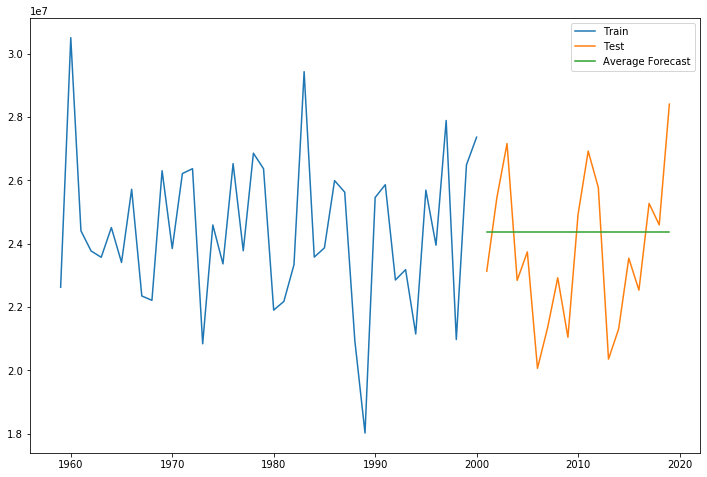

In [17]:
y_hat_avg = test.copy()
y_hat_avg['avg_forecast'] = train['summerspend'].mean()
plt.figure(figsize=(12,8))
plt.plot(train['summerspend'], label='Train')
plt.plot(test['summerspend'], label='Test')
plt.plot(y_hat_avg['avg_forecast'], label='Average Forecast')
plt.legend(loc='best')
plt.show()

In [18]:
rms = sqrt(mean_squared_error(test.summerspend, y_hat_avg.avg_forecast))
RMSE.append(rms)
print(rms)

# RMSE = 2404469.0779477805

2404469.0779477805


We can see the simple average can improve the score. The reason might be the time series is no trend.

##### Method 3  Moving Average

$$\hat{y}_{i} = \frac{1}{p}\sum^{i-1}_{t = i-p}{{y}_t}$$ where p is the timewindow

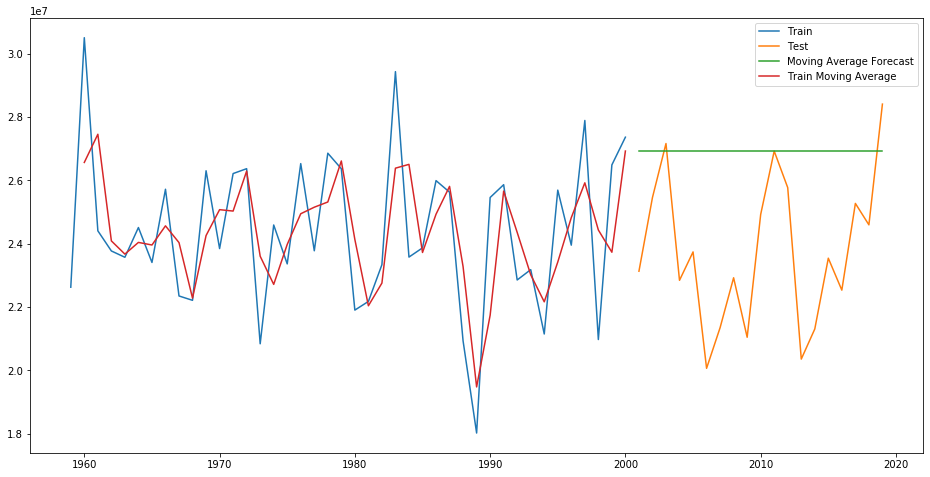

RMSe of Moving Average Model when p = 2 is 3931155.951810835


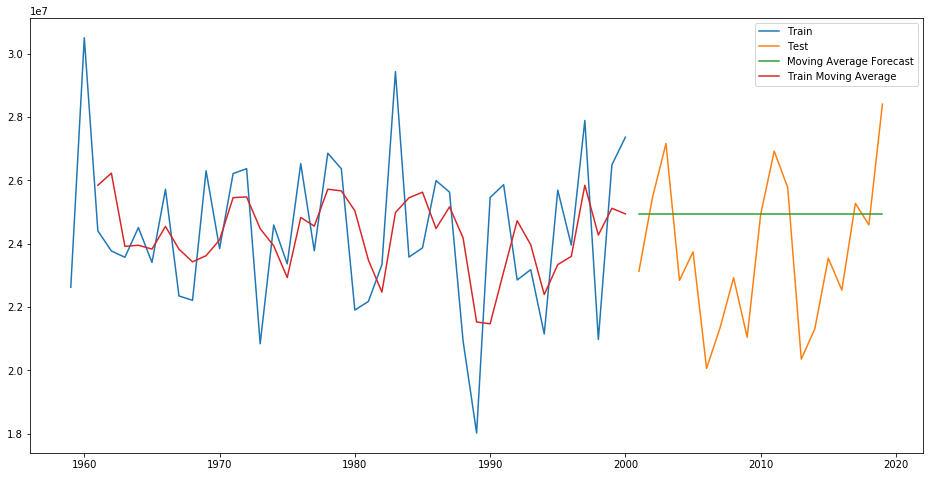

RMSe of Moving Average Model when p = 3 is 2608152.4815611592


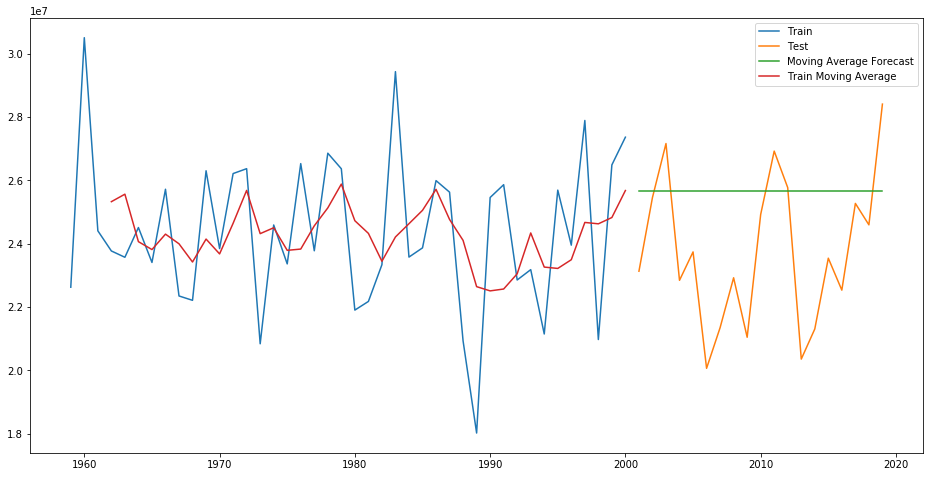

RMSe of Moving Average Model when p = 4 is 3016208.3383096172


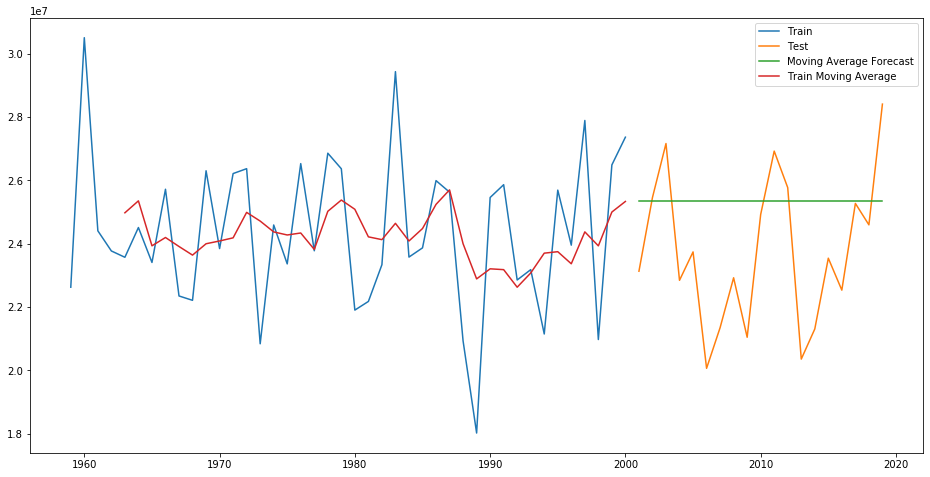

RMSe of Moving Average Model when p = 5 is 2808586.1769593935


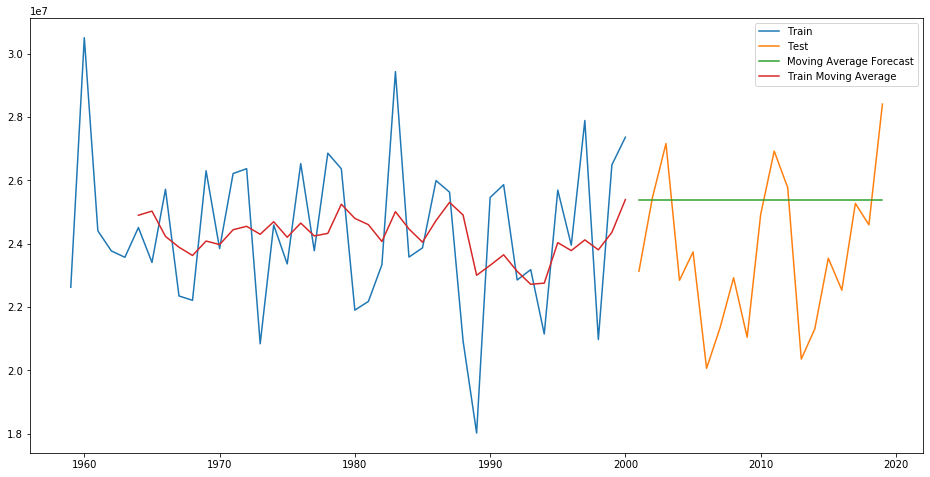

RMSe of Moving Average Model when p = 6 is 2842544.9815152325


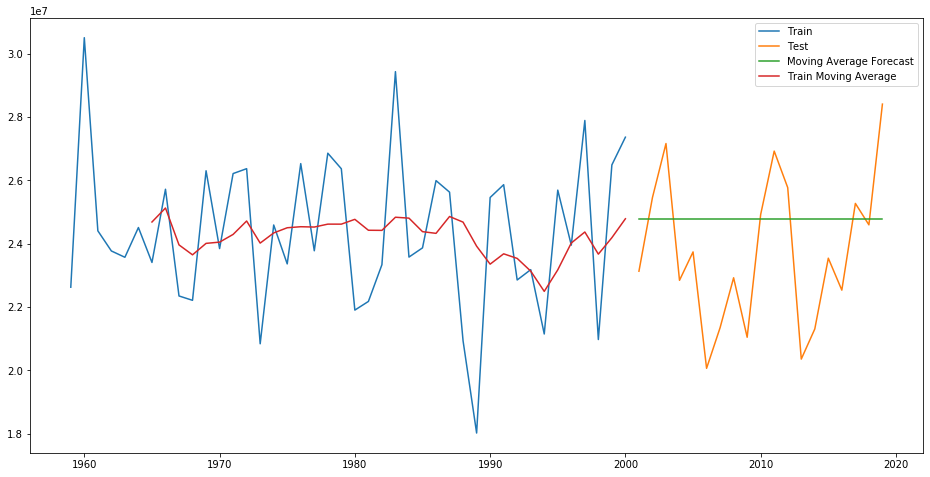

RMSe of Moving Average Model when p = 7 is 2541544.0900346516


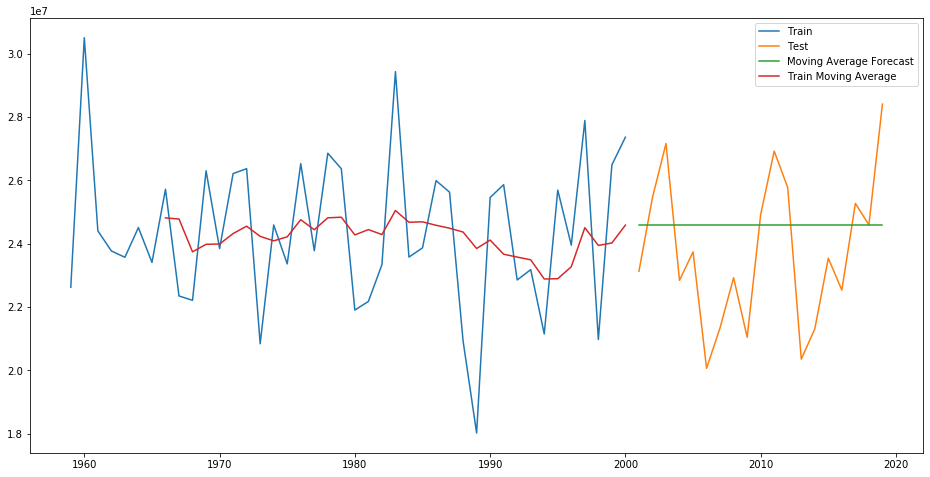

RMSe of Moving Average Model when p = 8 is 2466775.2099965443


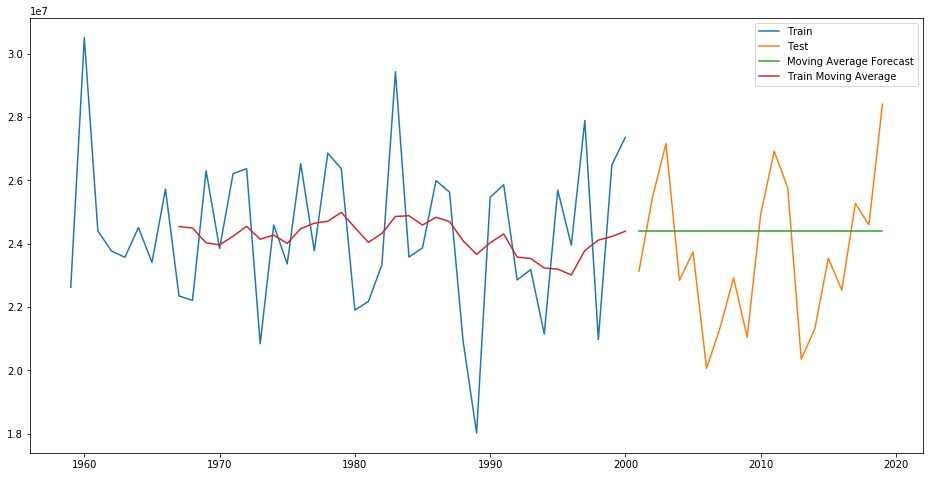

RMSe of Moving Average Model when p = 9 is 2408699.0105826296


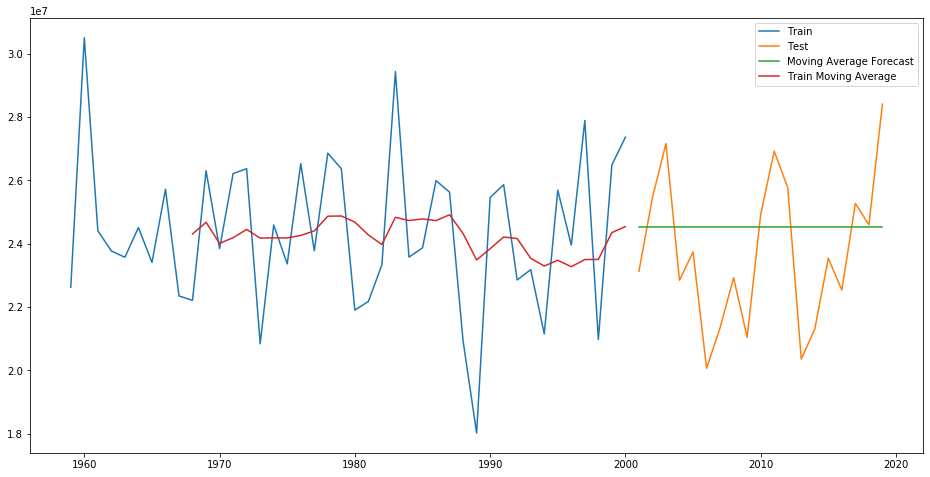

RMSe of Moving Average Model when p = 10 is 2451783.8706656103


In [19]:
p_number = []
rmse_value = []
for i in range(2,11):
        y_hat_avg = test.copy()
        y_hat_avg['moving_avg_forecast'] = train['summerspend'].rolling(i).mean().iloc[-1]
        plt.figure(figsize=(16,8))
        plt.plot(train['summerspend'], label='Train')
        plt.plot(test['summerspend'], label='Test')
        plt.plot(y_hat_avg['moving_avg_forecast'], label='Moving Average Forecast')
        plt.plot(train['summerspend'].rolling(i).mean(), label='Train Moving Average')
        plt.legend(loc='best')
        plt.show()
        rms = sqrt(mean_squared_error(test.summerspend, y_hat_avg.moving_avg_forecast))
        p_number.append(i)
        rmse_value.append(rms)
        print("RMSe of Moving Average Model when p =",i,"is",rms)

In [20]:
RMSE_MA = pd.DataFrame({"p_number" : p_number,"rmse_value" : rmse_value})
RMSE_MA

,p_number,rmse_value
0,2,3.931156e+06
1,3,2.608152e+06
2,4,3.016208e+06
3,5,2.808586e+06
4,6,2.842545e+06
5,7,2.541544e+06
6,8,2.466775e+06
7,9,2.408699e+06
8,10,2.451784e+06


In [21]:
RMSE_MA[RMSE_MA.rmse_value == RMSE_MA.rmse_value.min()]

,p_number,rmse_value
7,9,2.408699e+06


In Moving Average model, we use p = 9.

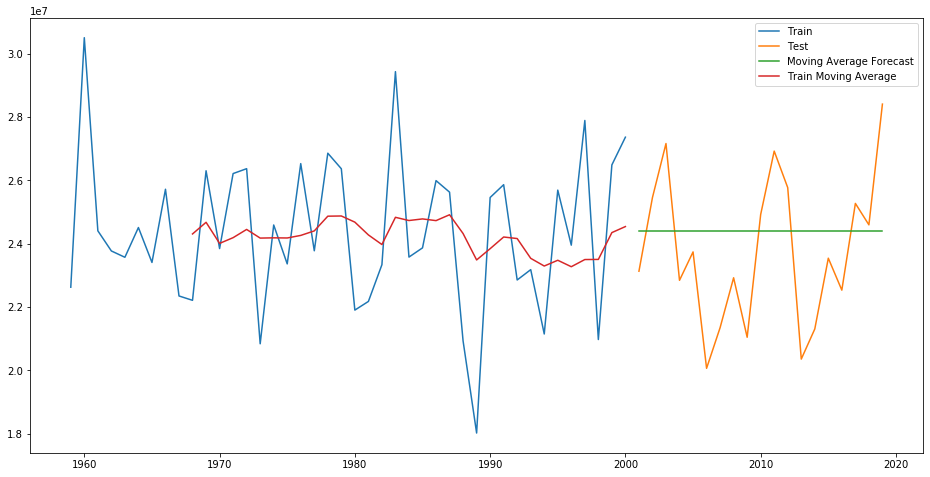

In [22]:
y_hat_avg = test.copy()
y_hat_avg['moving_avg_forecast'] = train['summerspend'].rolling(9).mean().iloc[-1]
plt.figure(figsize=(16,8))
plt.plot(train['summerspend'], label='Train')
plt.plot(test['summerspend'], label='Test')
plt.plot(y_hat_avg['moving_avg_forecast'], label='Moving Average Forecast')
plt.plot(train['summerspend'].rolling(i).mean(), label='Train Moving Average')
plt.legend(loc='best')
plt.show()

In [23]:
rms = sqrt(mean_squared_error(test.summerspend, y_hat_avg.moving_avg_forecast))
RMSE.append(rms)
rms

2408699.0105826296

##### Method 4  Simple Exponential Smoothing

$$\hat{y}_{t+1|t}=\alpha y_t + (1-\alpha) \hat{y}_{t|t-1} $$

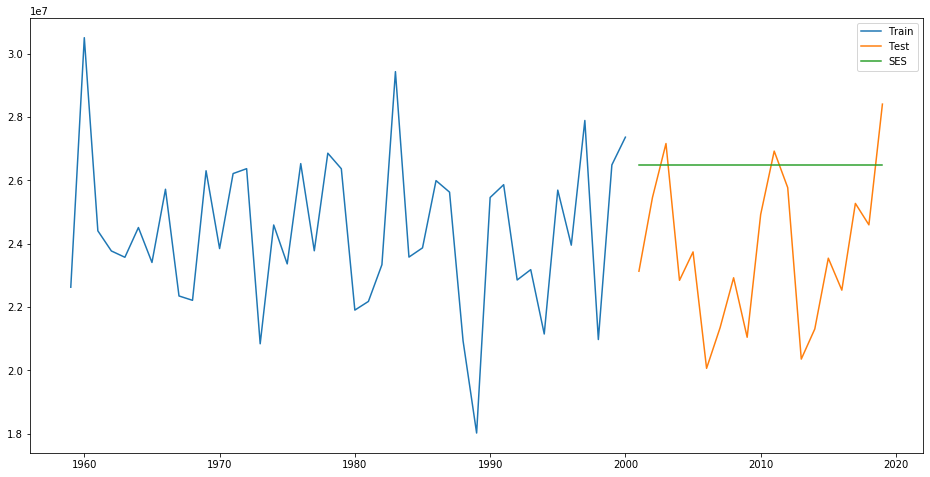

In [24]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing
y_hat_avg = test.copy()
fit2 = SimpleExpSmoothing(np.asarray(train['summerspend'])).fit(smoothing_level=0.6,optimized=False)
y_hat_avg['SES'] = fit2.forecast(len(test))
plt.figure(figsize=(16,8))
plt.plot(train['summerspend'], label='Train')
plt.plot(test['summerspend'], label='Test')
plt.plot(y_hat_avg['SES'], label='SES')
plt.legend(loc='best')
plt.show()

In [25]:
rms = sqrt(mean_squared_error(test.summerspend, y_hat_avg.SES))
RMSE.append(rms)
print(rms)

#RMSE = 3577811.749127613


3577811.749127613


##### Method 5  ARMA

In [26]:
ARMA_name = ["AR(1)","MA(1)","ARMA(1,1)"]
AIC = [] 
BIC = []

/Users/rihiko/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)


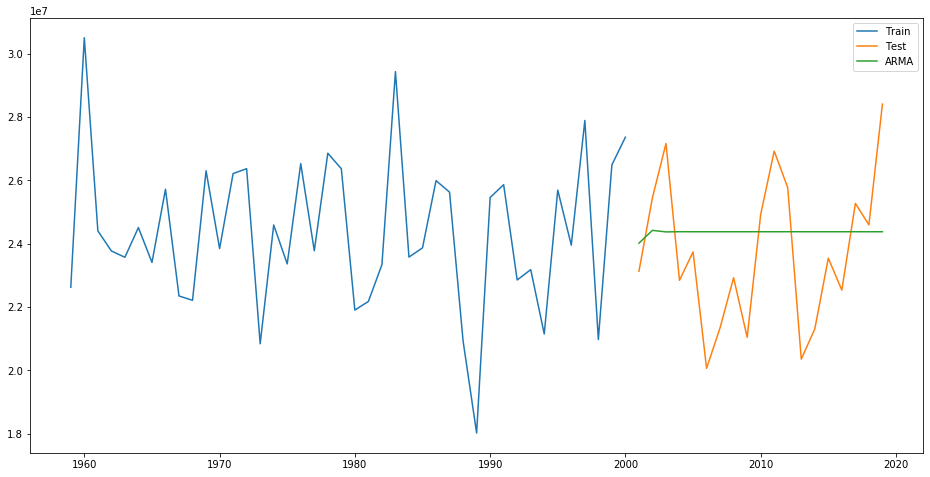

In [27]:
#AR(1)
y_hat_avg = test.copy()
fit1 = sm.tsa.ARMA(train.summerspend, order=(1,0)).fit()
y_hat_avg['ARMA'] = fit1.predict(start="2001-1-1", end="2019-1-1", dynamic=True)
plt.figure(figsize=(16,8))
plt.plot( train['summerspend'], label='Train')
plt.plot(test['summerspend'], label='Test')
plt.plot(y_hat_avg['ARMA'], label='ARMA')
plt.legend(loc='best')
plt.show()

In [28]:
AIC.append(fit1.aic)
BIC.append(fit1.bic)

/Users/rihiko/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)


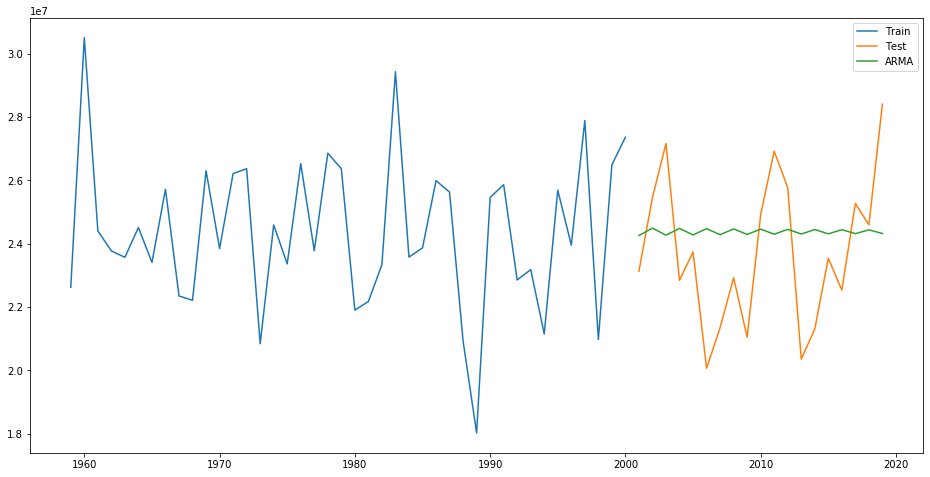

In [31]:
#ARMA(1,1)
y_hat_avg = test.copy()
fit3 = sm.tsa.ARMA(train.summerspend, order=(1,1)).fit()
y_hat_avg['ARMA'] = fit3.predict(start="2001-1-1", end="2019-1-1", dynamic=True)
plt.figure(figsize=(16,8))
plt.plot( train['summerspend'], label='Train')
plt.plot(test['summerspend'], label='Test')
plt.plot(y_hat_avg['ARMA'], label='ARMA')
plt.legend(loc='best')
plt.show()

In [32]:
AIC.append(fit3.aic)
BIC.append(fit3.bic)

In [33]:
ARMA_performance = pd.DataFrame({"ARMA_name" : ARMA_name,"AIC":AIC,"BIC":BIC})

In [34]:
ARMA_performance

,ARMA_name,AIC,BIC
0,AR(1),1359.187356,1364.400365
1,MA(1),1358.678832,1363.891841
2,"ARMA(1,1)",1361.446995,1368.397673


We select ARMA(1,1) with the largest AIC value and BIC value

/Users/rihiko/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)


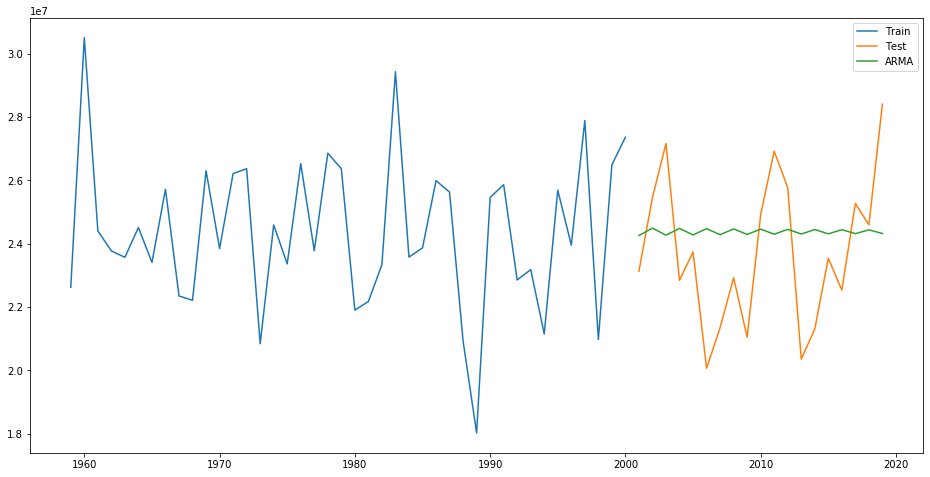

In [35]:
#ARMA(1,1)
y_hat_avg = test.copy()
fit3 = sm.tsa.ARMA(train.summerspend, order=(1,1)).fit()
y_hat_avg['ARMA'] = fit3.predict(start="2001-1-1", end="2019-1-1", dynamic=True)
plt.figure(figsize=(16,8))
plt.plot( train['summerspend'], label='Train')
plt.plot(test['summerspend'], label='Test')
plt.plot(y_hat_avg['ARMA'], label='ARMA')
plt.legend(loc='best')
plt.show()

In [36]:
rms = sqrt(mean_squared_error(test.summerspend, y_hat_avg.ARMA))
RMSE.append(rms)
print(rms)
#RMSE = 2415096.1564545105


2415096.1564545105


In [37]:
Model = ["Naive Model","Simple Average","Moving Average","Simple Exponential Smoothing","ARMA(1,1)"]

In [38]:
TS_performance = pd.DataFrame({"Model":Model,"RMSE":RMSE[:5]})
TS_performance
TS_performance.RMSE[1]
TS_performance[TS_performance.RMSE == TS_performance.RMSE.min()]

,Model,RMSE
1,Simple Average,2.404469e+06


To minimize RMSE, I select Simple Average model. For more precisely prediction, I use all the dataset to build the model. 

In [140]:
# Build Simple Average Model with all data


pred_dates = pd.date_range('2020-01-01', periods=5, freq='AS')
pred = pd.Series(data['summerspend'].mean(),index=pred_dates)
pred = pd.DataFrame(pred)
pred.columns = ["Forecast"]
pred

,Forecast
2020-01-01,2.418581e+07
2021-01-01,2.418581e+07
2022-01-01,2.418581e+07
2023-01-01,2.418581e+07
2024-01-01,2.418581e+07


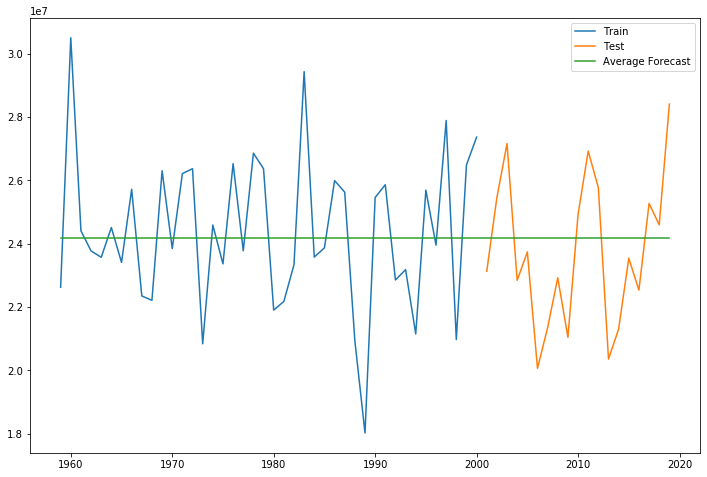

In [145]:
y_hat_avg = data.copy()
y_hat_avg['avg_forecast'] = data['summerspend'].mean()
plt.figure(figsize=(12,8))
plt.plot(train['summerspend'], label='Train')
plt.plot(test['summerspend'], label='Test')
plt.plot(y_hat_avg['avg_forecast'], label='Average Forecast')
plt.legend(loc='best')
plt.show()

According to Moving Average model, we predict the total spending in summer by greater NYC visitors to New England parks for each of the next five years are 24185805.88 dollars.

### Classification (25 points): 
Use the ​nyc_historical dataset to build a model that classifies households as season pass renewers or non-season pass renewers. All of the records in this dataset represent Greater NYC households that held Lobster Land family season passes. The final column, renew, indicates whether the family renewed its pass for the following season. Lobster Land management feels that this analysis can help them better understand New Yorkers in general.

In [40]:
nyc_historical =  pd.read_csv("nyc_historical.csv")

In [41]:
nyc_historical.head()

,householdID,visits,avgrides_perperson,avgmerch_perperson,avggoldzone_perperson,avgfood_perperson,goldzone_playersclub,own_car,homestate,FB_Like,renew
0,44,20,9.8,32.4,27.2,70.7,0,1,CT,1,1
1,57,20,11.7,71.8,40.8,1.6,0,1,CT,1,1
2,63,20,9.8,27.4,25.7,74.9,0,1,CT,1,1
3,159,17,2.2,1.5,91.1,28.9,1,1,CT,0,1
4,162,19,3.4,5.0,12.0,9.2,0,1,CT,0,1


In [42]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import random


#### Data Exploration and Preparation

In [163]:
nyc_historical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3200 entries, 0 to 3199
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   householdID            3200 non-null   int64  
 1   visits                 3200 non-null   int64  
 2   avgrides_perperson     3200 non-null   float64
 3   avgmerch_perperson     3200 non-null   float64
 4   avggoldzone_perperson  3200 non-null   float64
 5   avgfood_perperson      3200 non-null   float64
 6   goldzone_playersclub   3200 non-null   int64  
 7   own_car                3200 non-null   int64  
 8   homestate              3200 non-null   object 
 9   FB_Like                3200 non-null   int64  
 10  renew                  3200 non-null   int64  
dtypes: float64(4), int64(6), object(1)
memory usage: 275.1+ KB


##### Target Variable 

In [160]:
nyc_historical.renew.value_counts()

1    2126
0    1074
Name: renew, dtype: int64

This dataset is imbalanced, nearly 66% householders renewing the pass card. But fortunately, it is an extreme case. 
Dealing with slight imbalanced data, we will measure model performance with recall, F1 score, ROC curve, and its AUC

In [44]:
nyc_historical.homestate.value_counts()

NJ    1076
NY    1065
CT    1059
Name: homestate, dtype: int64

In [45]:
renew_data = nyc_historical

In [46]:
homestate_dummy = pd.get_dummies(nyc_historical.homestate)
homestate_dummy = homestate_dummy.drop(["CT"], axis=1)
homestate_dummy.rename(columns = {'NJ':'homestate_NJ'}, inplace = True) 
homestate_dummy.rename(columns = {'NY':'homestate_NY'}, inplace = True) 

renew_data = pd.concat([nyc_historical,homestate_dummy],axis = 1)
renew_data = renew_data.drop(['homestate'],axis = 1)

In [47]:
renew_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3200 entries, 0 to 3199
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   householdID            3200 non-null   int64  
 1   visits                 3200 non-null   int64  
 2   avgrides_perperson     3200 non-null   float64
 3   avgmerch_perperson     3200 non-null   float64
 4   avggoldzone_perperson  3200 non-null   float64
 5   avgfood_perperson      3200 non-null   float64
 6   goldzone_playersclub   3200 non-null   int64  
 7   own_car                3200 non-null   int64  
 8   FB_Like                3200 non-null   int64  
 9   renew                  3200 non-null   int64  
 10  homestate_NJ           3200 non-null   uint8  
 11  homestate_NY           3200 non-null   uint8  
dtypes: float64(4), int64(6), uint8(2)
memory usage: 256.4 KB


In [48]:
renew_data.head()

,householdID,visits,avgrides_perperson,avgmerch_perperson,avggoldzone_perperson,avgfood_perperson,goldzone_playersclub,own_car,FB_Like,renew,homestate_NJ,homestate_NY
0,44,20,9.8,32.4,27.2,70.7,0,1,1,1,0,0
1,57,20,11.7,71.8,40.8,1.6,0,1,1,1,0,0
2,63,20,9.8,27.4,25.7,74.9,0,1,1,1,0,0
3,159,17,2.2,1.5,91.1,28.9,1,1,0,1,0,0
4,162,19,3.4,5.0,12.0,9.2,0,1,0,1,0,0


In [49]:
# household ID is useless, so we drop it
renew_data = renew_data.drop(["householdID"],axis = 1) 

In [50]:
from sklearn.model_selection import train_test_split
X = renew_data[["visits","avgrides_perperson","avgmerch_perperson","avggoldzone_perperson","avgfood_perperson","goldzone_playersclub",
"own_car","FB_Like","homestate_NJ","homestate_NY"]]
y = renew_data["renew"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=21)

#### Feature Selection

##### 1. Compute the primary value ratio of each variable. 
If the ratio is larger than 85%, just delete it. We only keep the variables which can identify the target variable. 

In [51]:
def primaryvalue_ratio(data, ratiolimit = 1):     
    recordcount = data.shape[0]  #number of row
    x = []
    for col in data.columns:
        primaryvalue = data[col].value_counts().index[0]
        ratio = float(data[col].value_counts().iloc[0])/recordcount
        x.append([ratio,primaryvalue])       
    feature_primaryvalue_ratio = pd.DataFrame(x,index = data.columns)
    feature_primaryvalue_ratio.columns = ['primaryvalue_ratio','primaryvalue']

    needcol = feature_primaryvalue_ratio[feature_primaryvalue_ratio['primaryvalue_ratio']<ratiolimit]
    needcol = needcol.reset_index()
    select_data = data[list(needcol['index'])]
    return select_data  

In [52]:
def primaryvalue_ratio(data):
    recordcount = data.shape[0]  #number of row
    x = []
    for col in data.columns:
        primaryvalue = data[col].value_counts().index[0]
        ratio = float(data[col].value_counts().iloc[0])/recordcount
        x.append([primaryvalue,ratio])
    feature_primaryvalue_ratio = pd.DataFrame(x,index = data.columns)
    feature_primaryvalue_ratio.columns = ["primaryvalue","primaryvalue_ratio"]
    return feature_primaryvalue_ratio

In [53]:
d = primaryvalue_ratio(X_train)

In [54]:
d.sort_values(['primaryvalue_ratio'], ascending=[0])

,primaryvalue,primaryvalue_ratio
goldzone_playersclub,0.0,0.821429
own_car,1.0,0.750446
homestate_NJ,0.0,0.663393
homestate_NY,0.0,0.662054
FB_Like,0.0,0.537500
visits,2.0,0.144643
avgrides_perperson,10.0,0.022321
avgfood_perperson,18.4,0.005804
avgmerch_perperson,23.1,0.004464
avggoldzone_perperson,85.8,0.003571


As we can see, there is no variable being demonated by its primary value. Therefore, we keep all the variables. (we set the criticle point as 85%)

##### 2. Check the missing value

In [55]:
na_table = X_train.isnull().sum(axis = 0)/X_train.shape[0]

In [156]:
na_table # there is no missing value

visits                   0.0
avgrides_perperson       0.0
avgmerch_perperson       0.0
avggoldzone_perperson    0.0
avgfood_perperson        0.0
goldzone_playersclub     0.0
own_car                  0.0
FB_Like                  0.0
homestate_NJ             0.0
homestate_NY             0.0
dtype: float64

There is no missing value.

#### Modeling

In [252]:
Accuracy_train = []
Recall_train = []
F1_Score_train = []
Precision_train = []
Accuracy_test = []
Recall_test = []
F1_Score_test = []
Precision_test = []
AUC = []


##### Part I: Logistic Regression Model:

##### Correlation Analysis

Logistic regression is a linear model, therefore, we should do the correlation analysis to remove the multicorreltion

In [57]:
cor_table = X_train.corr()
cor_table

,visits,avgrides_perperson,avgmerch_perperson,avggoldzone_perperson,avgfood_perperson,goldzone_playersclub,own_car,FB_Like,homestate_NJ,homestate_NY
visits,1.000000,0.025168,0.006725,0.013401,0.005420,-0.002148,0.005085,0.001360,0.008360,-0.021332
avgrides_perperson,0.025168,1.000000,-0.020056,-0.013009,-0.014635,-0.022243,-0.019313,-0.025086,0.005241,0.018100
avgmerch_perperson,0.006725,-0.020056,1.000000,-0.003353,-0.018686,0.011748,-0.009070,-0.014066,0.003229,0.016020
avggoldzone_perperson,0.013401,-0.013009,-0.003353,1.000000,-0.031227,-0.020628,0.012132,-0.022254,0.017494,0.025145
avgfood_perperson,0.005420,-0.014635,-0.018686,-0.031227,1.000000,0.005289,-0.025119,0.037274,0.028503,-0.023999
goldzone_playersclub,-0.002148,-0.022243,0.011748,-0.020628,0.005289,1.000000,-0.030110,0.007014,0.018148,-0.002904
own_car,0.005085,-0.019313,-0.009070,0.012132,-0.025119,-0.030110,1.000000,0.028009,-0.017108,-0.006735
FB_Like,0.001360,-0.025086,-0.014066,-0.022254,0.037274,0.007014,0.028009,1.000000,0.009995,-0.032393
homestate_NJ,0.008360,0.005241,0.003229,0.017494,0.028503,0.018148,-0.017108,0.009995,1.000000,-0.508925
homestate_NY,-0.021332,0.018100,0.016020,0.025145,-0.023999,-0.002904,-0.006735,-0.032393,-0.508925,1.000000


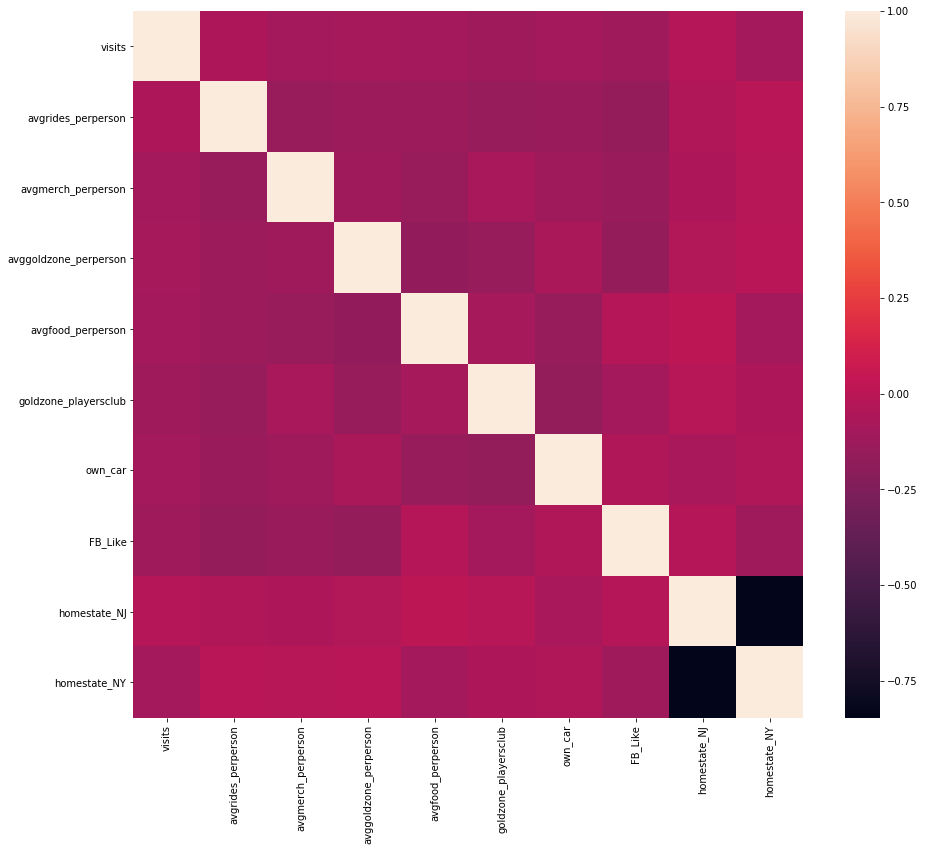

In [58]:
f, ax = plt.subplots(figsize=(15, 13))
sns.heatmap(cor_table.corr())

As we can see, there is no high correlations in our dataset

In [157]:
logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)

/Users/rihiko/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [158]:
logmodel.intercept_
logmodel.coef_

array([[ 0.11772918,  0.03811318,  0.00485627,  0.00292365,  0.00243818,
         0.52549573,  0.86123004, -0.10407854, -0.41440561, -0.27656558]])

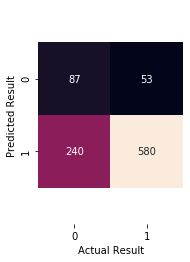

In [165]:
# prediction
predictions = logmodel.predict(X_test)
# confusion matrix
mat = confusion_matrix(predictions, y_test)
sns.heatmap(mat, square=True, annot=True, cbar=False,fmt='.20g')
plt.xlabel("Actual Result")
plt.ylabel("Predicted Result")
a, b = plt.ylim() 
a += 0.5 
b -= 0.5
plt.ylim(a, b)
plt.show()

In [166]:
pred_train = logmodel.predict(X_train)
print(classification_report(y_train, pred_train,digits=4))

              precision    recall  f1-score   support

           0     0.6476    0.3025    0.4124       747
           1     0.7245    0.9176    0.8097      1493

    accuracy                         0.7125      2240
   macro avg     0.6860    0.6101    0.6111      2240
weighted avg     0.6988    0.7125    0.6772      2240



In [167]:
print(classification_report(y_test, predictions,digits=4))

              precision    recall  f1-score   support

           0     0.6214    0.2661    0.3726       327
           1     0.7073    0.9163    0.7983       633

    accuracy                         0.6948       960
   macro avg     0.6644    0.5912    0.5855       960
weighted avg     0.6781    0.6948    0.6533       960



In [173]:
from sklearn import metrics
predslog_lr = logmodel.predict_proba(X_test)[:,1]
metrics.roc_auc_score(y_test,predslog_lr, average='macro', sample_weight=None)

0.6828171273147141

In [174]:
from sklearn.metrics import roc_curve, auc
import matplotlib as mpl  
import matplotlib.pyplot as plt
def plot_roc(labels, predict_prob):
    false_positive_rate,true_positive_rate,thresholds=roc_curve(labels, predict_prob)
    roc_auc=auc(false_positive_rate, true_positive_rate)
    plt.title('ROC')
    plt.plot(false_positive_rate, true_positive_rate,'b',label='AUC = %0.4f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.ylabel('TPR')
    plt.xlabel('FPR')

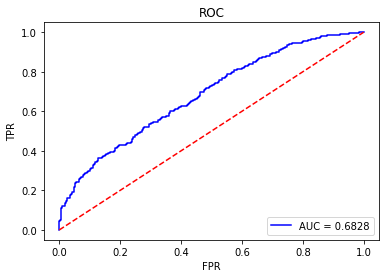

In [175]:
plot_roc(y_test,predslog_lr)

In [253]:
Accuracy_train.append(0.7125)
Recall_train.append(0.9176)
F1_Score_train.append(0.8097)
Precision_train.append(0.7245)
Accuracy_test.append(0.6948)
Recall_test.append(0.9163)
F1_Score_test.append(0.7983)
Precision_test.append(0.7073)
AUC.append(0.6828171273147141)

#### Part II​: ​Random Forest Model

In [181]:
from sklearn.ensemble import RandomForestClassifier
clf_rf=RandomForestClassifier(random_state = 654)
clf_rf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=654,
                       verbose=0, warm_start=False)

In [186]:
param_grid = {
    'n_estimators': [200],   # large n_estimators can predict more precise. Therefore, I only consider a large number, 200 trees.
    'max_depth': [2, 4, 6, 8], 
    'max_features': [2, 3, 4],  # In general, max_features should be set as sqrt of n_feature. sqrt(10) = 3 or 4
    'min_samples_leaf': [6, 8, 10, 12],  # smaller number of leaf would tend to capture the noise of dataset. Therefore, I set []
}

In [187]:
from sklearn.model_selection import GridSearchCV

CV_rfc = GridSearchCV(estimator=clf_rf, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train, y_train)
print(CV_rfc.best_params_)

{'max_depth': 8, 'max_features': 4, 'min_samples_leaf': 8, 'n_estimators': 200}


In [188]:
clf_rf=RandomForestClassifier(n_estimators=200, max_depth=8, max_features=4, min_samples_leaf=8, random_state=654)
clf_rf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8, max_features=4,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=8, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=654,
                       verbose=0, warm_start=False)

In [191]:
feature_imp_df = pd.DataFrame(list(zip(clf.feature_importances_, X_train)))
feature_imp_df.columns = ['feature importance', 'feature']
feature_imp_df = feature_imp_df.sort_values(by='feature importance', ascending=False)
feature_imp_df

,feature importance,feature
3,0.172435,avggoldzone_perperson
2,0.171391,avgmerch_perperson
0,0.166031,visits
4,0.162293,avgfood_perperson
1,0.160574,avgrides_perperson
8,0.048381,homestate_NJ
6,0.042721,own_car
9,0.027436,homestate_NY
7,0.025152,FB_Like
5,0.023588,goldzone_playersclub


* According to feature importance value, we can figure out the top 5 important features, which are avggoldzone_perperson, avgmerch_perperson, visits, avgfood_perperson and avgrides_perperson. These features have important value larger than 0.16, which means they are strongly predictable. 
* In general, when we have large size of features, we keep those have an importance of more than 0.15. However, our dataset is only have 10 variables. It doesn't matter to keep all the variables in random forest and the following XGBoost because they are not linear model. And more variables will keep more information. Therefore, we keep all the feature.

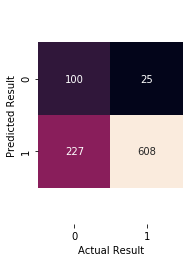

In [192]:
# prediction
predictions = clf_rf.predict(X_test)
# confusion matrix
mat = confusion_matrix(predictions, y_test)
sns.heatmap(mat, square=True, annot=True, cbar=False,fmt='.20g')
plt.xlabel("Actual Result")
plt.ylabel("Predicted Result")
a, b = plt.ylim() 
a += 0.5 
b -= 0.5
plt.ylim(a, b)
plt.show()

In [198]:
predictions = clf_rf.predict(X_train)
print(classification_report(y_train, predictions,digits=4))

              precision    recall  f1-score   support

           0     0.9233    0.4029    0.5610       747
           1     0.7670    0.9833    0.8618      1493

    accuracy                         0.7897      2240
   macro avg     0.8451    0.6931    0.7114      2240
weighted avg     0.8191    0.7897    0.7615      2240



In [199]:
predictions = clf_rf.predict(X_test)
print(classification_report(y_test, predictions,digits=4))

              precision    recall  f1-score   support

           0     0.8000    0.3058    0.4425       327
           1     0.7281    0.9605    0.8283       633

    accuracy                         0.7375       960
   macro avg     0.7641    0.6332    0.6354       960
weighted avg     0.7526    0.7375    0.6969       960



In [251]:
predslog_rf = clf_rf.predict_proba(X_test)[:,1]
metrics.roc_auc_score(y_test,predslog_rf, average='macro', sample_weight=None)

0.6974892628181901

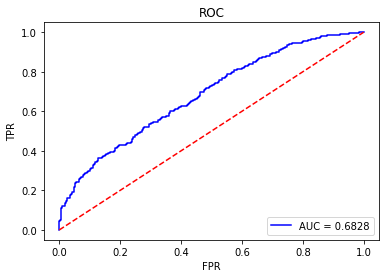

In [201]:
plot_roc(y_test,predslog_rf)

In [254]:
Accuracy_train.append(0.7897)
Recall_train.append(0.9833)
F1_Score_train.append(0.8618)
Precision_train.append(0.7670)
Accuracy_test.append(0.7375)
Recall_test.append(0.9605)
F1_Score_test.append(0.8283)
Precision_test.append(0.7281)
AUC.append(0.6974892628181901)

In [203]:
import xgboost as xgb
clf_xgb=xgb.XGBClassifier(random_state=654)
clf_xgb.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=654,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In XGBoost, I tuned hyperparameters in three steps.

In [ ]:
# step 1: n_estimators

In [212]:
cv_params = {'n_estimators': [200, 300, 400]}
other_params = {'learning_rate': 0.1, 'n_estimators': 500, 'max_depth': 5, 'min_child_weight': 1, 'seed': 0,
                    'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 1,'objective': 'binary:logistic'}



In [213]:
clf_xgb = xgb.XGBRegressor(**other_params)
optimized_GBM = GridSearchCV(estimator=clf_xgb, param_grid=cv_params, scoring='r2', cv=5, verbose=1, n_jobs=4) 
optimized_GBM.fit(X_train, y_train)


Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  35 out of  35 | elapsed:    8.6s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=0.8, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=5,
                                    min_child_weight=1, missing=None,
                                    n_estimators=500, n_jobs=1, nthread=None,
                                    objective='binary:logistic', random_state=0,
                                    reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=0, silent=None,
                                    subsample=0.8, verbosity=1),
             iid='deprecated', n_jobs=4,
             param_grid={'n_estimators': [200, 300, 400, 500, 600, 700, 800]},
             pre_dispatch='2*n_jobs', refit=True, 

In [215]:
optimized_GBM.best_params_

{'n_estimators': 200}

In [ ]:
# Step 2: max_depth & min_child_weight

In [224]:
cv_params = {'max_depth': list(range(1,5,1)), 'min_child_weight': [1, 2, 3, 4, 5, 6]}
other_params = {'learning_rate': 0.1, 'n_estimators': 200, 'max_depth': 5, 'min_child_weight': 1, 'seed': 0,
                    'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 1}

clf_xgb = xgb.XGBRegressor(**other_params)
optimized_GBM = GridSearchCV(estimator=clf_xgb, param_grid=cv_params, scoring='r2', cv=5, verbose=1, n_jobs=4) 
optimized_GBM.fit(X_train, y_train)


Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    4.1s
[Parallel(n_jobs=4)]: Done 120 out of 120 | elapsed:    7.4s finished


[00:24:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


GridSearchCV(cv=5, error_score=nan,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=0.8, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=5,
                                    min_child_weight=1, missing=None,
                                    n_estimators=200, n_jobs=1, nthread=None,
                                    objective='reg:linear', random_state=0,
                                    reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=0, silent=None,
                                    subsample=0.8, verbosity=1),
             iid='deprecated', n_jobs=4,
             param_grid={'max_depth': [1, 2, 3, 4],
                         'min_child_weight': [1, 2, 3, 4, 5, 6]},
             pre

In [225]:
optimized_GBM.best_params_

{'max_depth': 3, 'min_child_weight': 5}

In [ ]:
# Step 3: gamma

In [226]:
cv_params = {'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]}
other_params = {'learning_rate': 0.1, 'n_estimators': 200, 'max_depth': 3, 'min_child_weight': 5, 'seed': 0,
                    'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 1}

clf_xgb = xgb.XGBRegressor(**other_params)
optimized_GBM = GridSearchCV(estimator=clf_xgb, param_grid=cv_params, scoring='r2', cv=5, verbose=1, n_jobs=4) 
optimized_GBM.fit(X_train, y_train)


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.5s finished


[00:26:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


GridSearchCV(cv=5, error_score=nan,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=0.8, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=5, missing=None,
                                    n_estimators=200, n_jobs=1, nthread=None,
                                    objective='reg:linear', random_state=0,
                                    reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=0, silent=None,
                                    subsample=0.8, verbosity=1),
             iid='deprecated', n_jobs=4,
             param_grid={'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]},
             pre_dispatch='2*n_jobs', refit=True, return_train_scor

In [227]:
optimized_GBM.best_params_

{'gamma': 0.6}

In [ ]:
# step 4: subsample, colsample_bytree：

In [230]:
cv_params = {'subsample': [0.6, 0.7, 0.8, 0.9], 'colsample_bytree': [0.6, 0.7, 0.8, 0.9]}
other_params = {'learning_rate': 0.1, 'n_estimators': 200, 'max_depth': 3, 'min_child_weight': 5, 'seed': 0,
                    'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0.6, 'reg_alpha': 0, 'reg_lambda': 1}

In [231]:
clf_xgb = xgb.XGBRegressor(**other_params)
optimized_GBM = GridSearchCV(estimator=clf_xgb, param_grid=cv_params, scoring='r2', cv=5, verbose=1, n_jobs=4) 
optimized_GBM.fit(X_train, y_train)
optimized_GBM.best_params_

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.9s
[Parallel(n_jobs=4)]: Done  80 out of  80 | elapsed:    5.3s finished


[00:31:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


{'colsample_bytree': 0.9, 'subsample': 0.9}

In [ ]:
# step 5: regalpha & reglambda

In [232]:
cv_params = {'reg_alpha': [0.05, 0.1, 1, 2, 3], 'reg_lambda': [0.05, 0.1, 1, 2, 3]}
other_params = {'learning_rate': 0.1, 'n_estimators': 200, 'max_depth': 3, 'min_child_weight': 5, 'seed': 0,
                    'subsample': 0.9, 'colsample_bytree': 0.9, 'gamma': 0.6, 'reg_alpha': 0, 'reg_lambda': 1}

In [233]:
clf_xgb = xgb.XGBRegressor(**other_params)
optimized_GBM = GridSearchCV(estimator=clf_xgb, param_grid=cv_params, scoring='r2', cv=5, verbose=1, n_jobs=4) 
optimized_GBM.fit(X_train, y_train)
optimized_GBM.best_params_

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.2s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:    8.8s finished


[00:33:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


{'reg_alpha': 3, 'reg_lambda': 0.05}

In [234]:
cv_params = {'learning_rate': [0.01, 0.05, 0.07, 0.1, 0.2]}
other_params = {'learning_rate': 0.1, 'n_estimators': 200, 'max_depth': 3, 'min_child_weight': 5, 'seed': 0,
                    'subsample': 0.9, 'colsample_bytree': 0.9, 'gamma': 0.6, 'reg_alpha': 3, 'reg_lambda': 0.05}

In [235]:
clf_xgb = xgb.XGBRegressor(**other_params)
optimized_GBM = GridSearchCV(estimator=clf_xgb, param_grid=cv_params, scoring='r2', cv=5, verbose=1, n_jobs=4) 
optimized_GBM.fit(X_train, y_train)
optimized_GBM.best_params_

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    2.1s finished


[00:33:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


{'learning_rate': 0.1}

In [236]:
clf_xgb = xgb.XGBClassifier(n_estimators=200, max_depth=3, 
                            learning_rate=0.1, subsample=0.9, colsample_bytree=0.9,scale_pos_weight=3.0, 
                             silent=True, nthread=-1, seed=0, missing=None,objective='binary:logistic', 
                             reg_alpha=3, reg_lambda=0.05, 
                             gamma=0.6, min_child_weight=5, 
                             max_delta_step=0,base_score=0.5)

clf_xgb.fit(X_train, y_train)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9, gamma=0.6,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=5, missing=None, n_estimators=200, n_jobs=1,
              nthread=-1, objective='binary:logistic', random_state=0,
              reg_alpha=3, reg_lambda=0.05, scale_pos_weight=3.0, seed=0,
              silent=True, subsample=0.9, verbosity=1)

In [237]:
# feature importance 
feature_imp_df = pd.DataFrame(list(zip(clf_xgb.feature_importances_, X_train)))
feature_imp_df.columns = ['feature importance', 'feature']
feature_imp_df = feature_imp_df.sort_values(by='feature importance', ascending=False)
feature_imp_df

,feature importance,feature
8,0.321522,homestate_NJ
6,0.151555,own_car
0,0.135880,visits
9,0.095966,homestate_NY
5,0.075694,goldzone_playersclub
1,0.061954,avgrides_perperson
3,0.043305,avggoldzone_perperson
4,0.041291,avgfood_perperson
2,0.038462,avgmerch_perperson
7,0.034371,FB_Like


* According to feature importance value, it is noticable that homestate_NJ is the most important feature. Next is own_car, visits. These variables are strongly predictable.

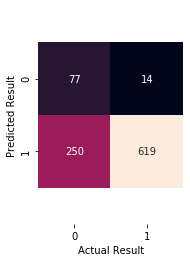

In [241]:
# prediction
predictions = clf_xgb.predict(X_test)
# confusion matrix
mat = confusion_matrix(predictions, y_test)
sns.heatmap(mat, square=True, annot=True, cbar=False,fmt='.20g')
plt.xlabel("Actual Result")
plt.ylabel("Predicted Result")
a, b = plt.ylim() 
a += 0.5 
b -= 0.5
plt.ylim(a, b)
plt.show()

In [242]:
predictions = clf_xgb.predict(X_train)
print(classification_report(y_train, predictions,digits=4))

              precision    recall  f1-score   support

           0     0.9598    0.2878    0.4428       747
           1     0.7361    0.9940    0.8458      1493

    accuracy                         0.7585      2240
   macro avg     0.8480    0.6409    0.6443      2240
weighted avg     0.8107    0.7585    0.7114      2240



In [243]:
predictions = clf_xgb.predict(X_train)
print(classification_report(y_train, predictions,digits=4))

              precision    recall  f1-score   support

           0     0.9598    0.2878    0.4428       747
           1     0.7361    0.9940    0.8458      1493

    accuracy                         0.7585      2240
   macro avg     0.8480    0.6409    0.6443      2240
weighted avg     0.8107    0.7585    0.7114      2240



In [255]:
predslog_rf = clf_xgb.predict_proba(X_test)[:,1]
metrics.roc_auc_score(y_test,predslog_rf, average='macro', sample_weight=None)

0.6981704518553946

In [257]:
Accuracy_train.append(0.7585)
Recall_train.append(0.9940)
F1_Score_train.append(0.8458)
Precision_train.append(0.7361)
Accuracy_test.append(0.7585)
Recall_test.append(0.9940)
F1_Score_test.append(0.8458)
Precision_test.append(0.7361)
AUC.append(0.6981704518553946)

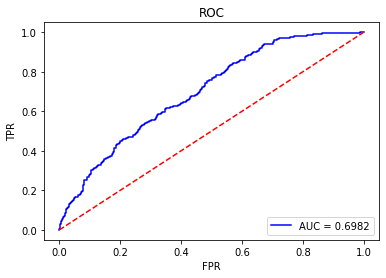

In [259]:
plot_roc(y_test,predslog_rf)

In [260]:
name = ["Logistic Regression","Random Forest", "XGBoost"]

In [280]:
clf_performance = pd.DataFrame({"Accuracy_test" :Accuracy_test,"Recall_test": Recall_test,"F1_Score_test": F1_Score_test,
                                "Precision_test": Precision_test,"AUC":AUC,
                                "Accuracy_train" : Accuracy_train,"Recall_train":Recall_train,"F1_Score_train" :F1_Score_train,
                                "Precision_train": Precision_train},index = name)

In [281]:
clf_performance

,Accuracy_test,Recall_test,F1_Score_test,Precision_test,AUC,Accuracy_train,Recall_train,F1_Score_train,Precision_train
Logistic Regression,0.6948,0.9163,0.7983,0.7073,0.682817,0.7125,0.9176,0.8097,0.7245
Random Forest,0.7375,0.9605,0.8283,0.7281,0.697489,0.7897,0.9833,0.8618,0.7670
XGBoost,0.7585,0.9940,0.8458,0.7361,0.698170,0.7585,0.9940,0.8458,0.7361


##### As shown in the performance matrix, XGBoost is the best model with greatest accuracy, recall, f1 score, precision, AUC
Because this data is imbalanced, so we focus on  recall, f1 score, precision and AUC.